# Unsupervised Learning and Convolutional Autoencoder for Image Anomaly Detection

In [26]:
# import packages

import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, InputLayer
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [27]:
from keras.datasets import fashion_mnist
from keras.datasets import mnist

#### the autoencoder reconstructs the normal data with a smaller error

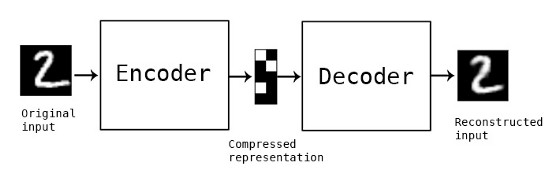

#### the anomaly data with a larger error

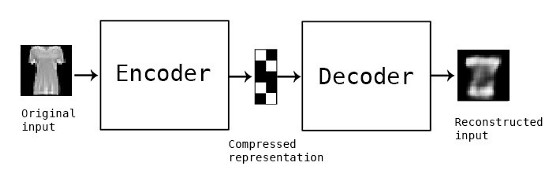

#### Use the reconstruction error to identify anomaly

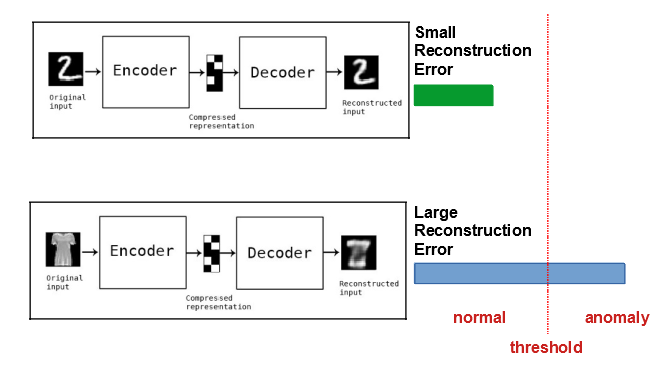

## Load Dataset

#### MNIST Data

In [28]:
(X_train_1, y_train_1), (X_test_1, y_test_1) = mnist.load_data()
print (X_train_1.shape)
print (X_test_1.shape)
print (y_train_1.shape)
print (y_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [29]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_test_1, y_test_1, test_size=0.1)
print (X_train_1.shape)
print (X_test_1.shape)
print (y_train_1.shape)
print (y_test_1.shape)

(9000, 28, 28)
(1000, 28, 28)
(9000,)
(1000,)


#### Fashion MNIST

In [30]:
(X_train_2, y_train_2), (X_test_2, y_test_2) = fashion_mnist.load_data()
print (X_train_2.shape)
print (y_train_2.shape)
print (X_test_2.shape)
print (y_test_2.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [31]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_test_2, y_test_2, test_size=0.1)
print (X_train_2.shape)
print (y_train_2.shape)
print (X_test_2.shape)
print (y_test_2.shape)

(9000, 28, 28)
(9000,)
(1000, 28, 28)
(1000,)


#### Prepare Dataset

In [32]:
X_test = np.concatenate((X_test_1, X_test_2))
y_test = np.concatenate((y_test_1, y_test_2))
print (X_test.shape)
print (y_test.shape)

(2000, 28, 28)
(2000,)


#### We will normalize all values between 0 and 1

In [37]:
x_train = X_train_1.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
print (x_train.shape)
print (x_test.shape)

(9000, 28, 28, 1)
(2000, 28, 28, 1)


## Build Model

### Convolutional autoencoder

In [38]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [39]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 8)           0   

In [61]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

h = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                verbose=0,
                #validation_data=(x_test, x_test),
                validation_split=0.2)

Text(0.5, 0, 'Epochs')

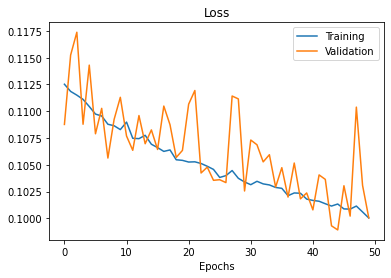

In [62]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [42]:
def visualize(img,autoencoder):
    """Draws original, encoded and decoded images"""
    #code = encoded.predict(img[None])[0]
    reco = autoencoder.predict(img[None])[0]

    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(np.clip(img.reshape(28,28) + 0.5, 0, 1))

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.imshow(np.clip(reco.reshape(28,28) + 0.5, 0, 1))
    
    plt.show()

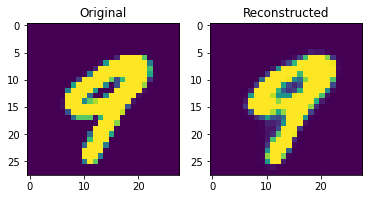

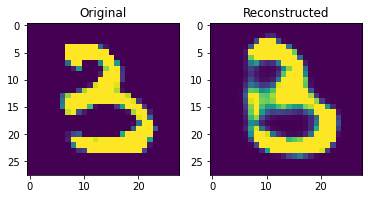

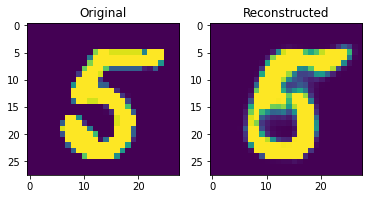

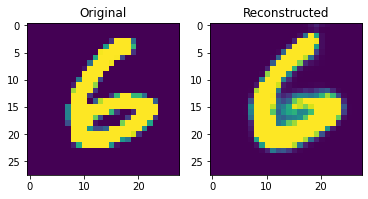

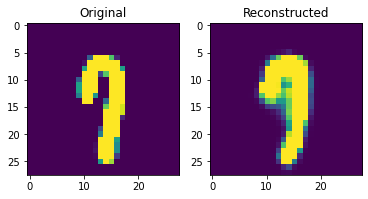

In [43]:
for i in range(5):
    img = x_test[i]
    visualize(img,autoencoder)

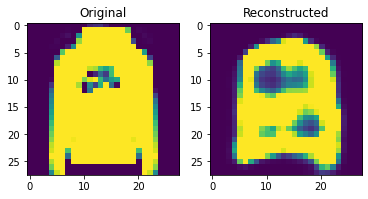

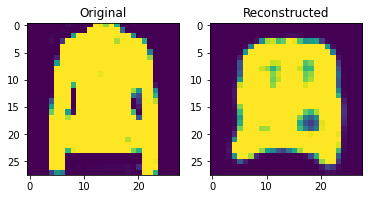

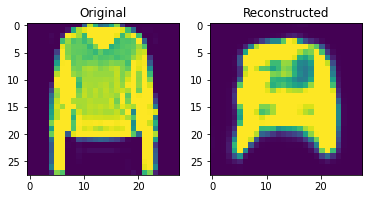

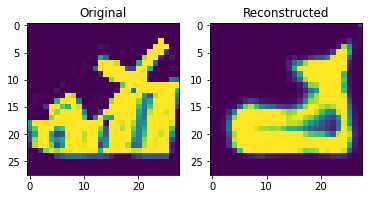

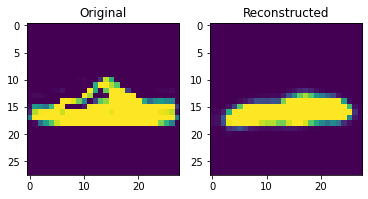

In [47]:
for i in range(5):
    img = x_test[i-5]
    visualize(img,autoencoder)

In [48]:
imgtest = x_test[-5]

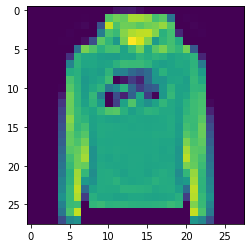

In [49]:
plt.imshow(imgtest.reshape(28,28))

In [50]:
reco_test = autoencoder.predict(imgtest[None])[0]

In [56]:
test_x_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) \
                       - test_x_predictions.reshape((len(test_x_predictions), np.prod(test_x_predictions.shape[1:]))),\
                       2), axis=1)

In [58]:
error_df = pd.DataFrame({'Reconstruction_error': mse})

In [59]:
error_df.head()

,Reconstruction_error
0,0.012654
1,0.020555
2,0.025858
3,0.017657
4,0.010725


In [60]:
error_df.tail()

,Reconstruction_error
1995,0.052359
1996,0.078728
1997,0.038625
1998,0.059505
1999,0.023308
